# 🎬 Netflix Data Exploration

This project explores the Netflix dataset to uncover trends in movies and TV shows — such as most common genres, ratings, and content growth over time.

---


## 1 Introduction
** Goal:** `netflix_titles.csv` from Kaggle. 
**Tools:** Python, pandas, seaborn, matplotlib.

---


In [1]:
# Import core libraries for data analysis and visualisation
import pandas as pd          # for data manipulation
import numpy as np           # for numerical operations
import matplotlib.pyplot as plt   # for charts
import seaborn as sns        # for advanced visualisations
from pathlib import Path     # to create folders safely (like /images)

# Configure display and style
pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")  # gives all charts a clean white background

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## 1️⃣ Load and Preview the Dataset

We’ll now load the Netflix dataset (`netflix_titles.csv`) into a pandas DataFrame.  
After that, we’ll inspect the first few rows to confirm it loaded correctly.


In [2]:
# define the relative file path (make sure netflix_titles.csv is in your /data folder)
data_path = "data/netflix_titles.csv"

# Load the csv into a dataframe
df = pd.read_csv(data_path)

# print the shape to see rows and colums count
print("✅ Loaded dataset successfully! Shape:", df.shape)

# display the first 5 records as a preview
df.head()

✅ Loaded dataset successfully! Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## 2️⃣ Understand the Dataset

Before cleaning or analysis, we’ll inspect:
- Column names and data types (`.info()`)
- Summary statistics (`.describe()`)
- Any missing values


In [3]:
# show column data types and non null counts
df.info()

# show summary statistics for numeric and object columns
df.describe(include='all').T

# Check for missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("\n🧩 Missing values per column:")
print(missing[missing>0] if missing.sum()>0 else "No missing values detected.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

🧩 Missing values per column:
director      2634
country        831
cast           825
date_added      10
rating           4
duration         3
dtype: int64


## 3️⃣ Data Cleaning

Goals in this step:
- Parse `date_added` to real dates and extract `year_added` for time-series charts.
- Standardise text: trim spaces and lower noise.
- Handle missing values in key text columns (`director`, `cast`, `country`, `rating`, `listed_in`).
- Normalise list-like columns (genres and countries) so later analysis is easier.
- Quick sanity checks (duplicates and basic value counts).



In [4]:
# -----------------------------
# DATA CLEANING (Netflix)
# -----------------------------

import numpy as np
import pandas as pd

# 1) Parse dates and derive year
#    errors='coerce' turns bad strings into NaT (missing datetime) instead of crashing
# Converts the text column "date_added" into real date format (e.g. “2021-09-25” instead of plain text).
# errors='coerce' means if a date is bad or blank, make it NaT (missing) instead of crashing.
# The second line makes a new column year_added which stores only the year (like 2021).

df['date_added'] = pd.to_datetime(df.get('date_added'),errors='coerce')
df['year_added'] = df['date_added'].dt.year


# 2) Standardise whitespace in core string columns ( strip leading/ trailing spaces)
# Replaces missing values (NaN) with empty strings.
# Converts everything to string type (so you don’t get type errors).
# Removes any extra spaces at the start/end (like “ Drama ” → “Drama”).


text_cols = ['title', 'type', 'rating', 'country', 'listed_in', 'director', 'cast', 'description']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna('').astype(str).str.strip()

# 3) Fill sensible "unknown" labels for key categoricals so counts/plots don't drop rows
# After cleaning, some fields may be blank (“”).
 # We replace those blanks with “Unknown” — this keeps them visible in graphs instead of disappearing.

if 'rating' in df.columns:
    df['rating'] = df['rating'].replace('', 'Unknown')
if 'country' in df.columns:
    df['country'] = df['country'].replace('', 'Unknown')
if 'director' in df.columns:
    df['director'] = df['director'].replace('', 'Unknown')
if 'cast' in df.columns:
    df['cast'] = df['cast'].replace('', 'Unknown')
    
# 4) Optional: Normalise title casing for 'type' (Movie / TV Show) in case of weird casing
# ➡️ Makes sure all entries in the type column have proper casing.
# If someone typed “movie” or “tv show”, it becomes “Movie” and “Tv Show”.

if 'type' in df.columns:
    df['type'] = df['type'].str.title()  # e.g., "tv show" -> "Tv Show"

# 5) Quick duplicate check (same show_id appears twice)
#    If duplicates exist, keep the first occurrence
# It prints a short message if anything was deleted.

if 'show_id' in df.columns:
    before = len(df)
    df = df.drop_duplicates(subset=['show_id'], keep='first')
    after = len(df)
    if after < before:
        print(f"🧹 Removed {before - after} duplicate row(s) by show_id.")

# 6) Create helper columns that will make later analysis easier
#    - Clean genre list ready for explode (we'll explode later in EDA)

if 'listed_in' in df.columns:
    df['genres_list'] = df['listed_in'].str.split(',').apply(lambda lst: [g.strip() for g in lst if g.strip()])

#    - Clean country list
if 'country' in df.columns:
    df['countries_list'] = df['country'].str.split(',').apply(lambda lst: [c.strip() for c in lst if c.strip() and c.strip().lower() != 'unknown'])

# 7) Sanity prints so you can see the effect of cleaning
#How many “Movies” vs “TV Shows”
#Top 5 ratings (e.g., TV-MA, PG-13)
#How many rows now have valid year_added

print("✅ Cleaning done.")
print("Distinct types:", df['type'].value_counts().to_dict() if 'type' in df.columns else "N/A")
print("Top ratings:", df['rating'].value_counts().head(5).to_dict() if 'rating' in df.columns else "N/A")
print("Rows with valid year_added:", int(df['year_added'].notna().sum()))
df.head(3)


✅ Cleaning done.
Distinct types: {'Movie': 6131, 'Tv Show': 2676}
Top ratings: {'TV-MA': 3207, 'TV-14': 2160, 'TV-PG': 863, 'R': 799, 'PG-13': 490}
Rows with valid year_added: 8709


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,genres_list,countries_list
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,[Documentaries],[United States]
1,s2,Tv Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,"[International TV Shows, TV Dramas, TV Mysteries]",[South Africa]
2,s3,Tv Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,"[Crime TV Shows, International TV Shows, TV Ac...",[]


## 4️⃣ Exploratory Data Analysis (EDA)

Now that the data is clean, let's explore it visually to understand Netflix’s trends and content patterns.

We'll answer:
- How has Netflix's catalogue grown over time?
- Which ratings (TV-MA, PG-13, etc.) appear most?
- What are the most common genres?
- Which countries produce the most Netflix titles?


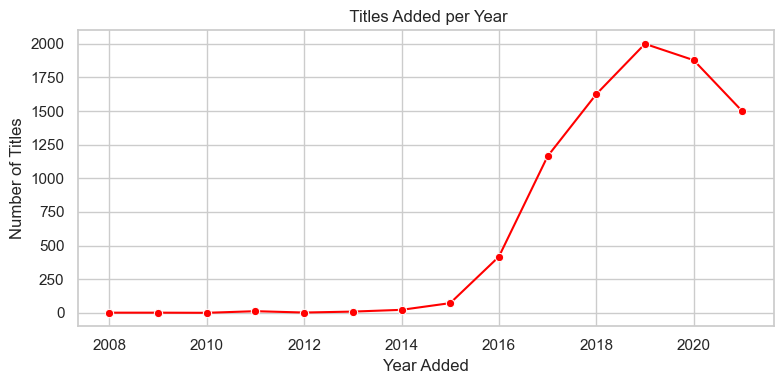

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure /images folder exists
Path("images").mkdir(exist_ok=True)

# Count titles per year
titles_per_year = (
    df.dropna(subset=['year_added'])
      .groupby('year_added')['show_id']
      .count()
      .reset_index(name='count')
)

# Plot
plt.figure(figsize=(8,4))
sns.lineplot(data=titles_per_year, x='year_added', y='count', marker='o', color='red')
plt.title(" Titles Added per Year")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.tight_layout()
plt.savefig("images/titles_per_year.png", dpi=150)
plt.show()


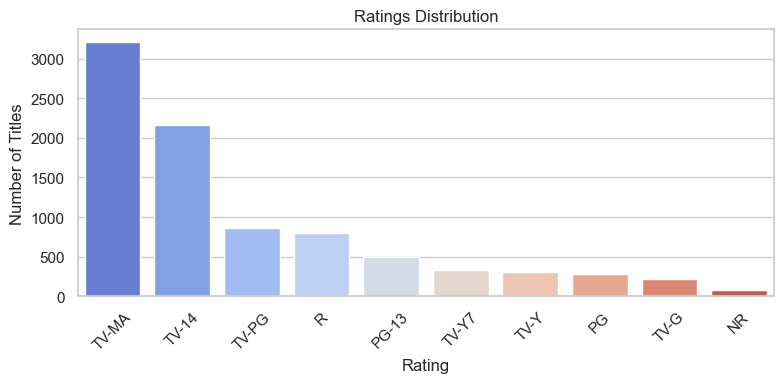

In [11]:
# Count how many titles fall under each rating (TV-MA, PG, etc.)
ratings = (
    df['rating']
      .value_counts()
      .head(10)
      .reset_index()
)
ratings.columns = ['Rating', 'Count']  # explicitly set column names

plt.figure(figsize=(8,4))
sns.barplot(data=ratings, x='Rating', y='Count', hue='Rating', legend=False, palette='coolwarm')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/ratings_distribution.png", dpi=150)
plt.show()


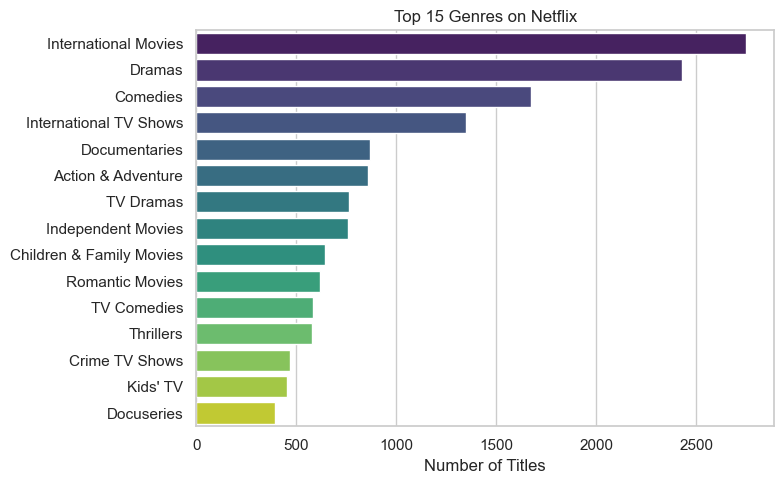

In [12]:
# Break comma-separated genre strings into individual genre rows
genres = (
    df.assign(genre=df['listed_in'].str.split(','))
      .explode('genre')
)
genres['genre'] = genres['genre'].str.strip()  # remove extra spaces
genres = genres[genres['genre'] != '']         # drop blank entries

# Count top 15 genres
top_genres = (
    genres['genre']
        .value_counts()
        .head(15)
        .reset_index()
)
top_genres.columns = ['Genre', 'Count']  # force correct column names

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=top_genres, y='Genre', x='Count', hue='Genre',
            legend=False, palette='viridis')
plt.title("Top 15 Genres on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("")
plt.tight_layout()
plt.savefig("images/top_genres.png", dpi=150)
plt.show()


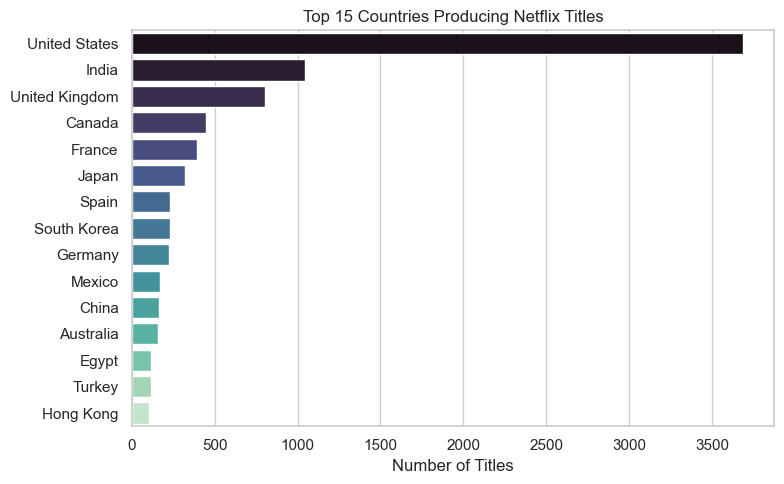

✅ Saved: images/top_countries.png


In [13]:
# 5D — Top Producing Countries

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Path("images").mkdir(exist_ok=True)

# Split the comma-separated country field and clean it
countries = (
    df.assign(country_split=df['country'].str.split(','))
      .explode('country_split')
)
countries['country_split'] = (
    countries['country_split']
      .fillna('')
      .astype(str)
      .str.strip()
)

# Drop blanks and "Unknown"
countries = countries[
    (countries['country_split'] != '') &
    (countries['country_split'].str.lower() != 'unknown')
]

# Count top 15 countries
top_countries = (
    countries['country_split']
        .value_counts()
        .head(15)
        .reset_index()
)
top_countries.columns = ['Country', 'Count']   # force consistent names

# Plot (use hue to avoid seaborn deprecation warning)
plt.figure(figsize=(8,5))
sns.barplot(
    data=top_countries,
    y='Country', x='Count',
    hue='Country', legend=False, palette='mako'
)
plt.title("Top 15 Countries Producing Netflix Titles")
plt.xlabel("Number of Titles")
plt.ylabel("")
plt.tight_layout()
plt.savefig("images/top_countries.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved: images/top_countries.png")
